In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr

matplotlib.rcParams['figure.figsize'] = (25, 5)

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC


In [2]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 5
cfg.obs_dim = 20
cfg.p_factor = 2
cfg.covar_factor = np.eye(cfg.factor_dim)/100
cfg.p_eps = 5
cfg.covar_eps = np.eye(cfg.obs_dim)/1000
cfg.T = 300


## Nonlinear decoder DGP
Obtain the simulated $y$

Obtained stable system after 153 iterations.
Obtained stable system after 195 iterations.
Theoretical optimal mse for f, y, enc: 0.333


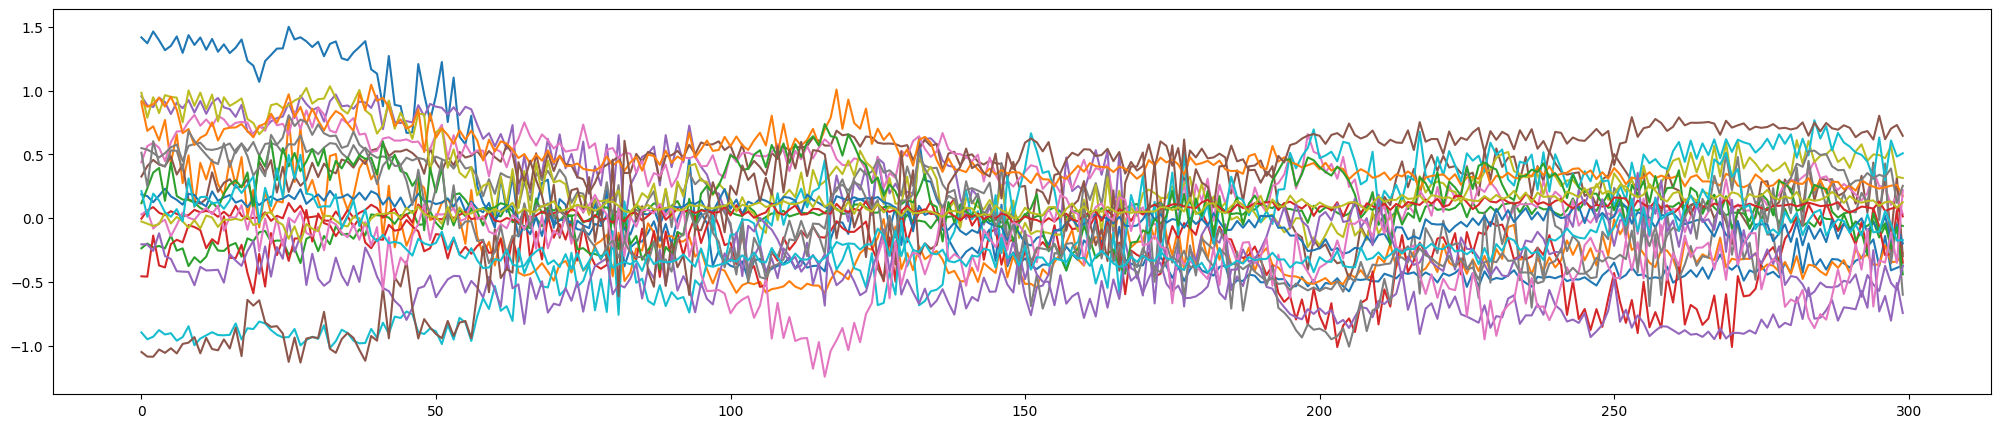

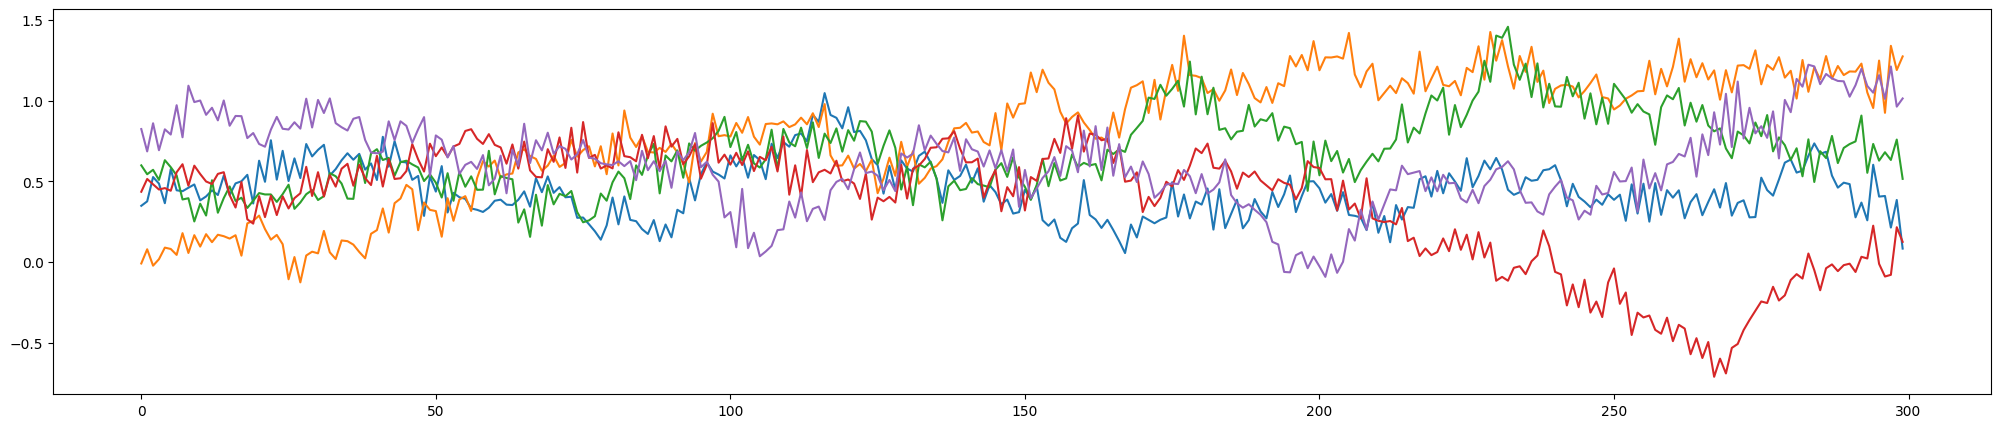

In [24]:
init_function = lambda params: torch.nn.init.sparse_(params, 0.0, std=0.25)
dec = Decoder(hidden_dim=[cfg.factor_dim, 20,40,60,80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, init_function = init_function)
f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps)
plt.plot(y);
plt.figure()
#plt.plot(obs_residual);
#plt.figure()
#plt.plot(y-obs_residual);
#plt.figure()
plt.plot(f);

In [421]:
#j = jacobian(dec, torch.Tensor(f[0]).float()).detach().numpy()
#cov = j @ cfg.covar_factor @ j.T
#cov.shape

## Estimate nonlinear model
TODO: this should all be hyperparameter tuned etc.

In [422]:
def cca_callback_gen(mod, f):
    def cca_callback(train_hist):
        if 'cca_r2' not in train_hist.keys():
            train_hist['cca_r2'] = []
        f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
        f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
        cc = np.mean(CanCorr(f_hat, f).cancorr)
        train_hist['cca_r2'].append(cc)
    return cca_callback
        

In [423]:
dec = Decoder(hidden_dim=[cfg.factor_dim, 30, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False)
enc = Encoder(hidden_dim=[cfg.obs_dim, 30, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainanle paramaters {get_trainable_params(mod)}")
#criterion = BasicAutoEncoder.model.OrthoLoss(enc=enc, alpha=10)
cback  = cca_callback_gen(mod, f)
train_hist = train(X=y,model=mod,n_epoch=3000, lr = 0.0001, epoch_callback=cback)
print(f"Training loss: {train_hist['loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainanle paramaters 1585
300 2


KeyboardInterrupt: 

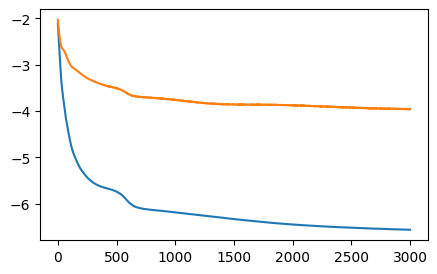

In [386]:
plot_train_hist(train_hist, log=True)

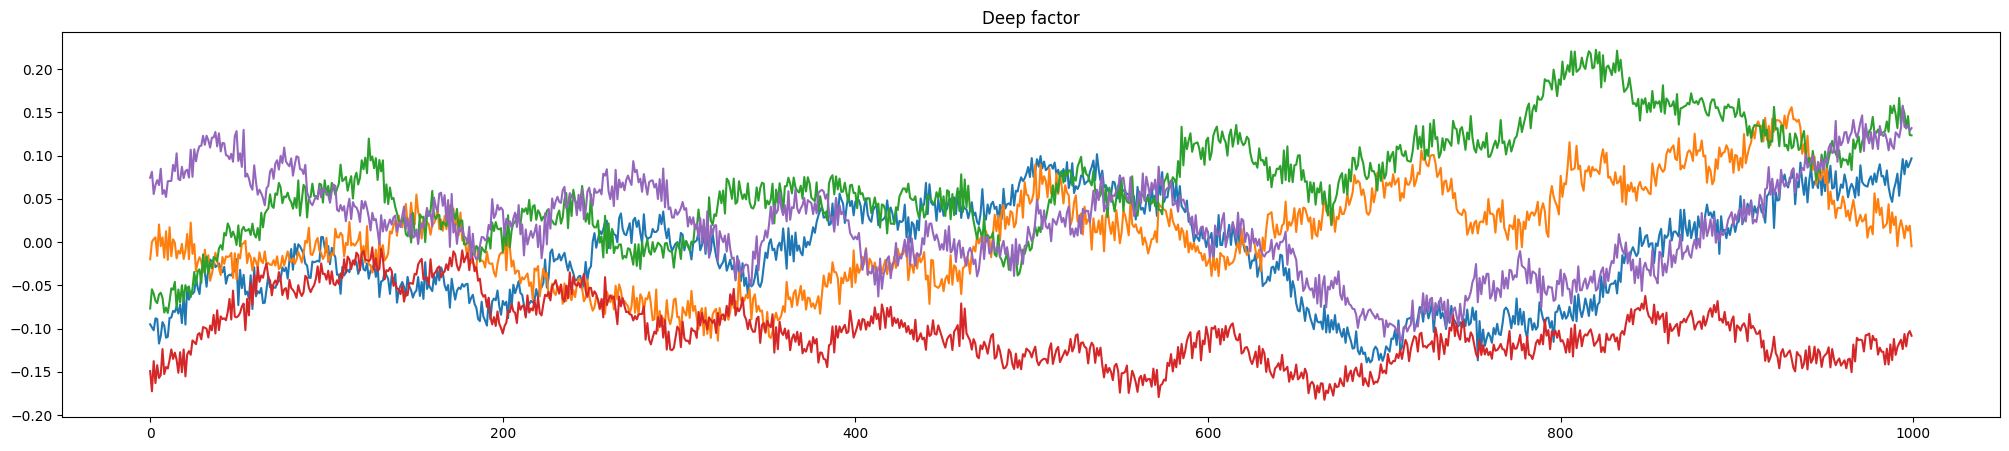

In [415]:
plot_factor_estimates(mod, y)

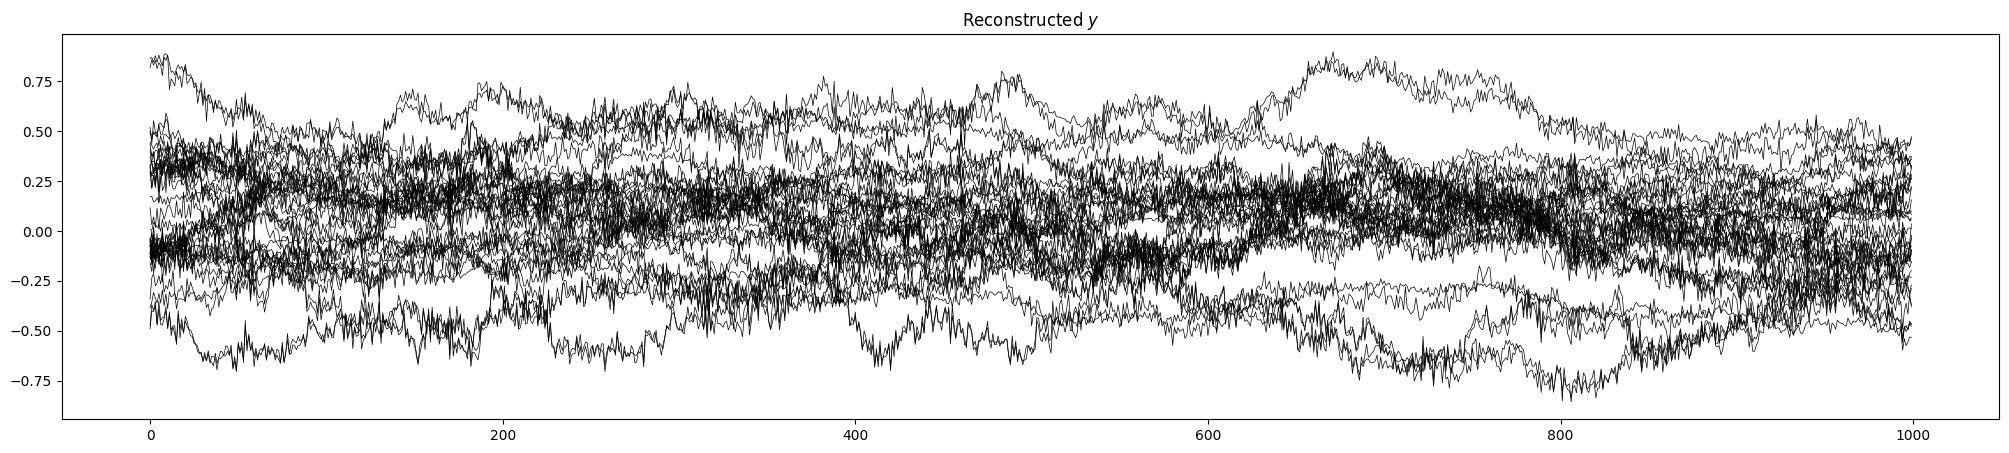

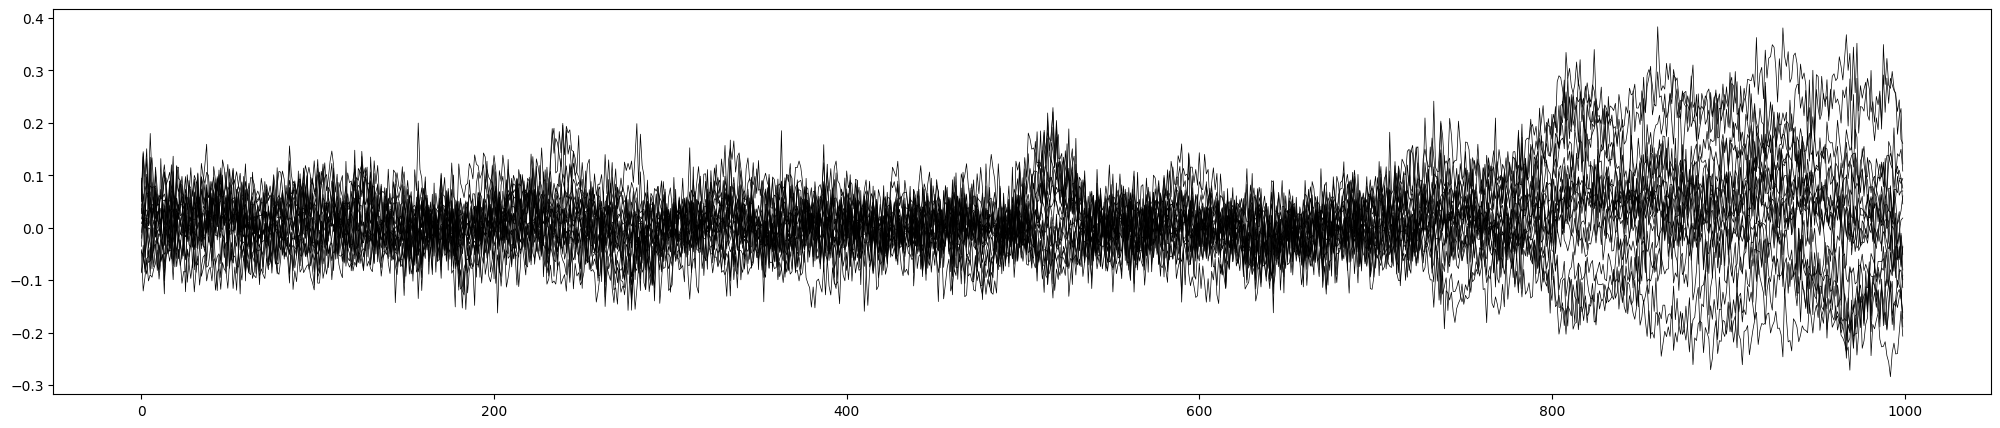

In [414]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);

y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

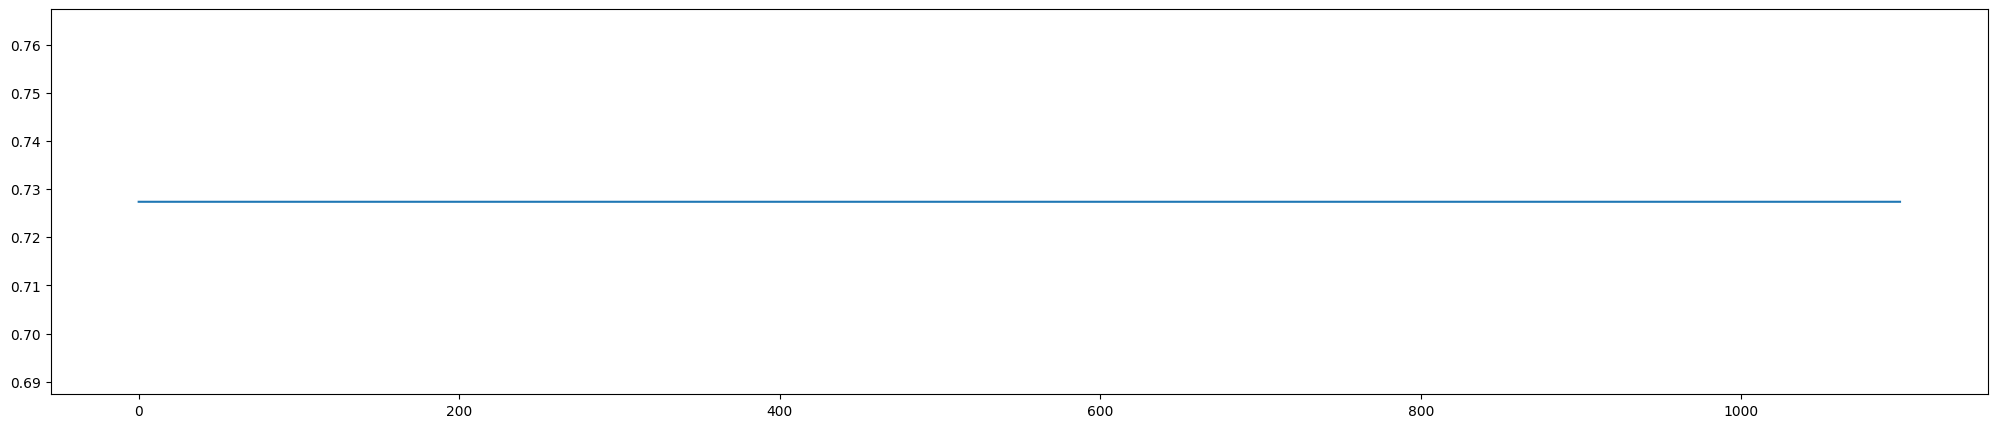

In [416]:
plt.plot(train_hist['cca_r2'])

In [518]:
dec = Decoder(hidden_dim=[cfg.factor_dim, 30, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False)
enc = Encoder(hidden_dim=[cfg.obs_dim, 30, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainanle paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
train_hist = trainMCMC(X=y,model=mod, errorProcess = errorProcess, n_epoch=100, lr = 0.0001, epoch_callback=cback)
print(f"Training loss: {train_hist['loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainanle paramaters 1585
300 89
210 0.73306623427640832764083
210 0.0166005460811512881151284
210 0.0097807282227135842713584
210 0.0100035149903435890343586
210 0.0095584531237060833706083
210 0.0113202948877144437714443
210 0.0107177425497433269743326
210 0.00789480422778676277867635
210 0.00682403537932605993260595
210 0.00551953859505287950528795
210 0.00571897868565949856594935
Training loss: 0.00571897868565949, Validation Loss: 0.01658618182278751


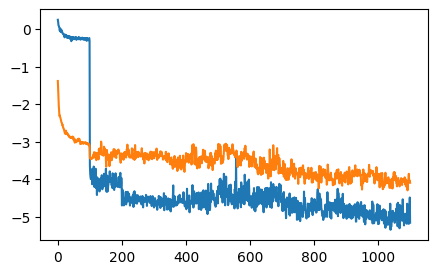

In [521]:
plot_train_hist(train_hist, log=True)

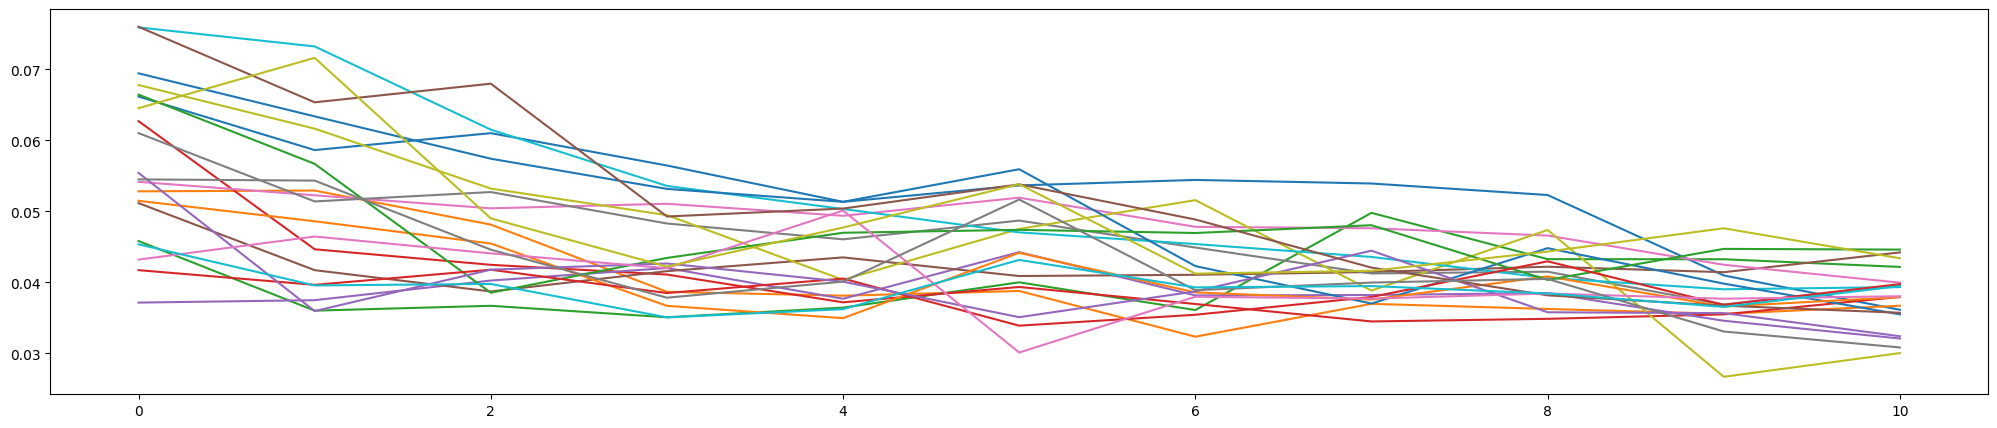

In [529]:
plt.plot(np.sqrt(np.vstack(errorProcess.fit_hist['var'][1:])));

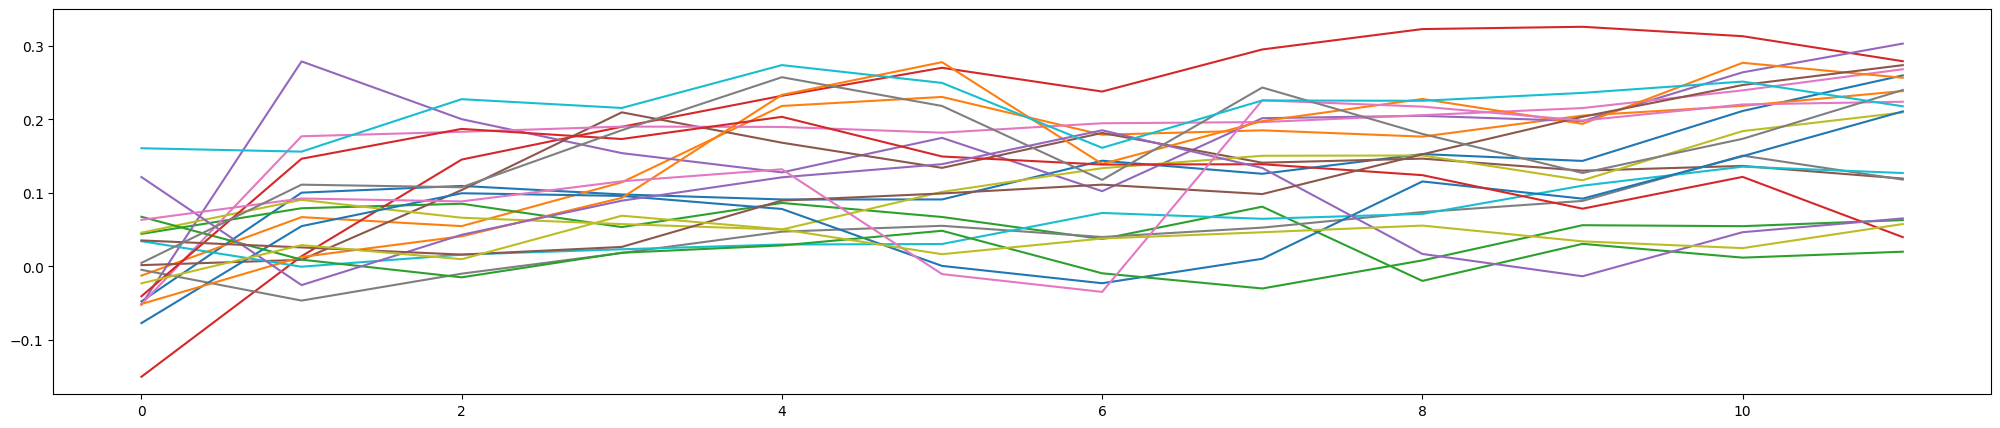

In [530]:
plt.plot(np.stack(errorProcess.fit_hist['coeff'])[:,:,4]);

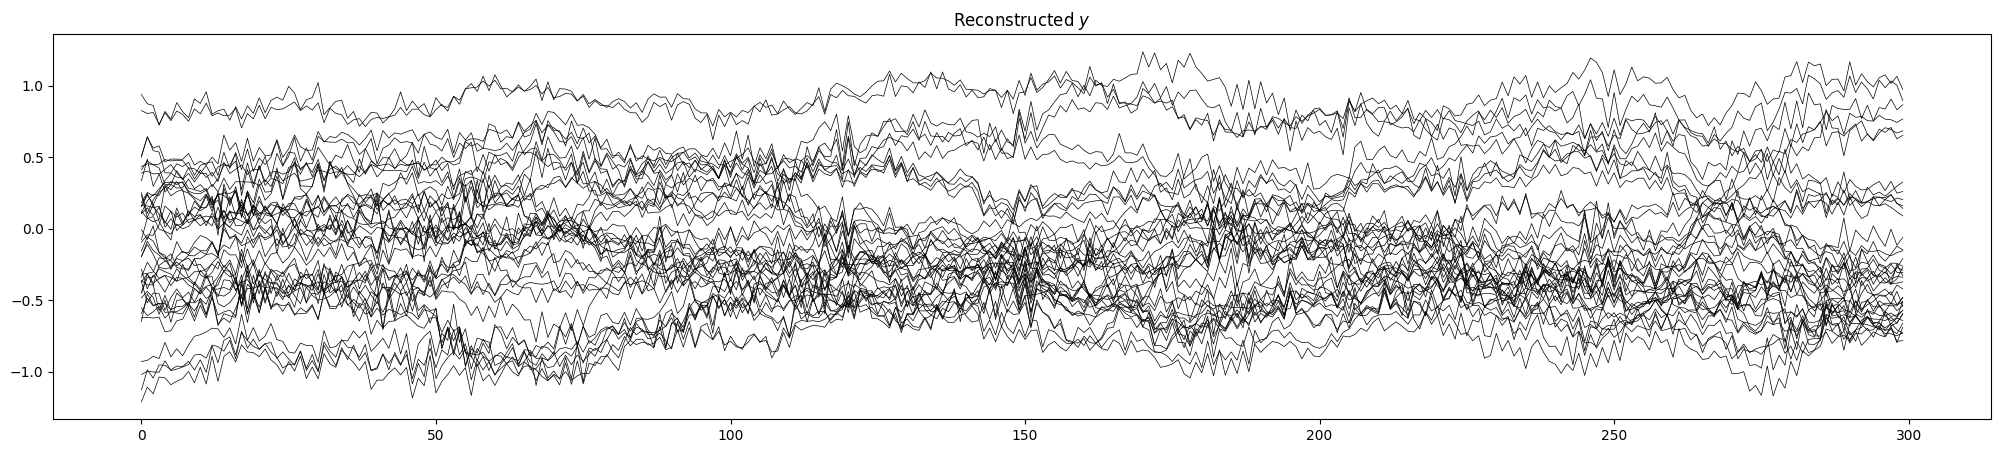

In [515]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


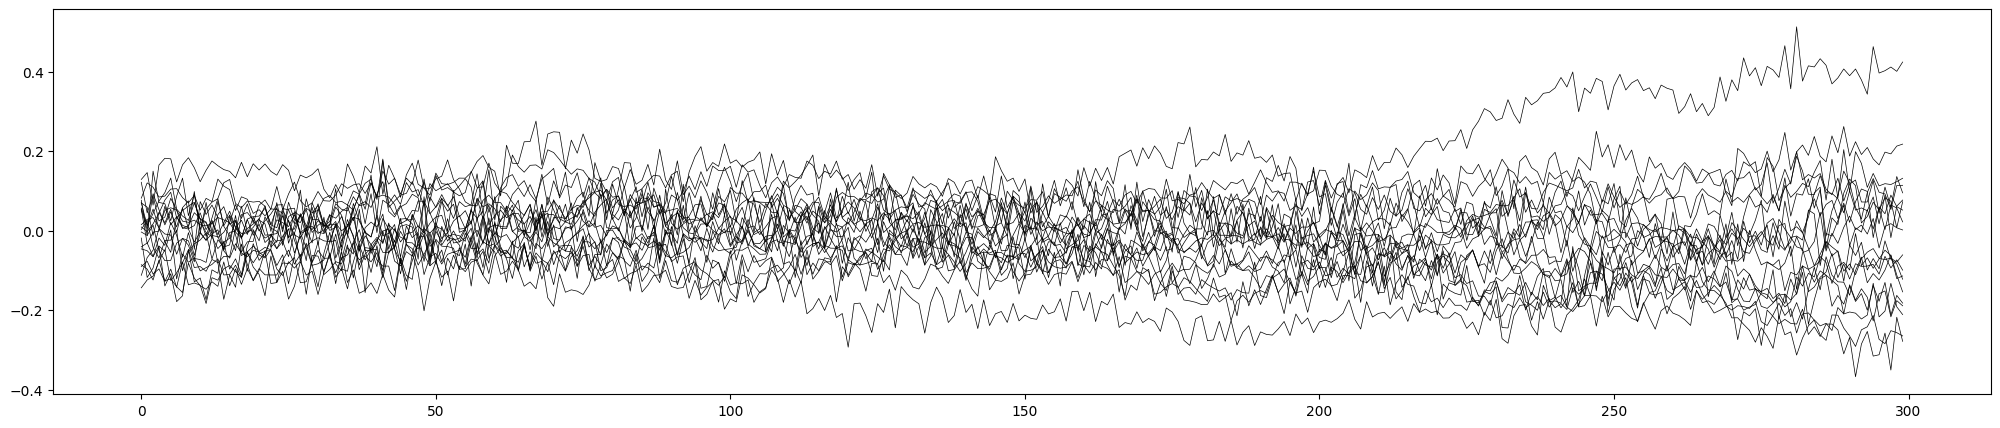

In [517]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

In [487]:
errorProcess.fitted[0].param_names

['ar.L1', 'ar.L2', 'ar.L3', 'ar.L4', 'ar.L5', 'sigma2']

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

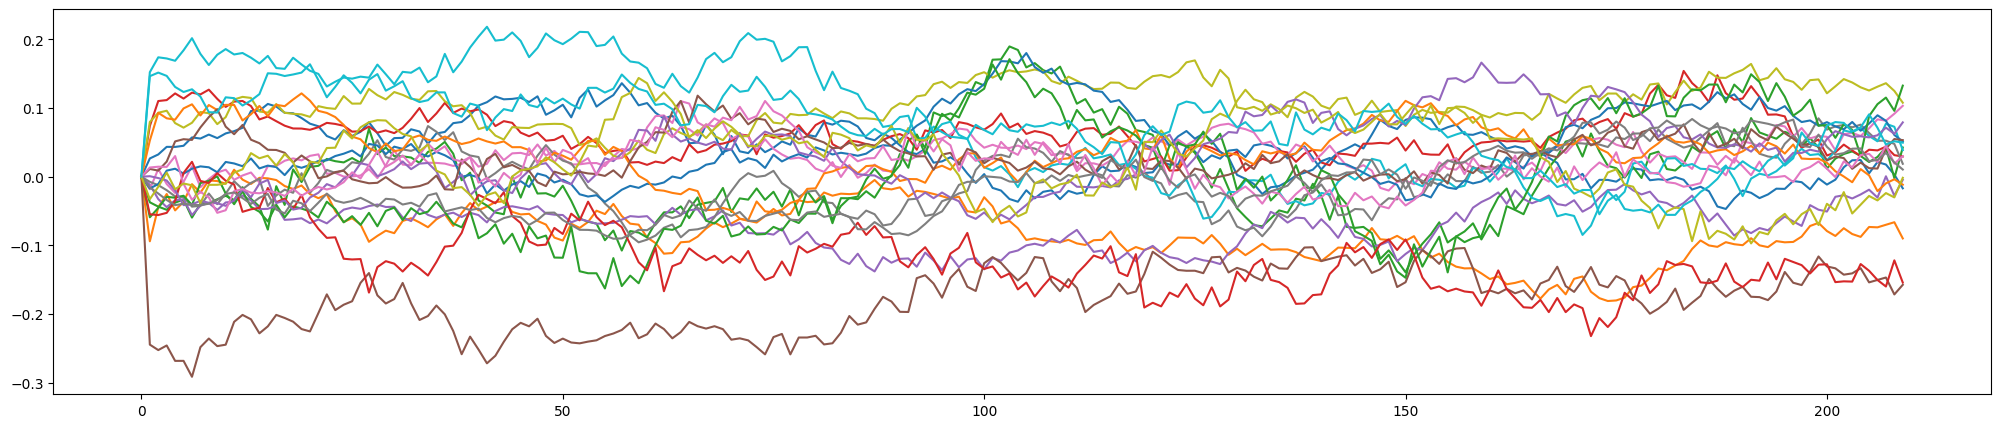

<Figure size 2500x500 with 0 Axes>

In [531]:
plt.plot(errorProcess.conditionalExpectation());
plt.figure()
plt.plot(errorProcess.predict(y_pred-y));

In [311]:
beta = np.linalg.inv(f.T@f)@f.T@f_hat

In [312]:
beta

array([[-0.51785763,  0.38508444,  0.32079042,  0.19148854, -0.115364  ],
       [-0.10627955, -0.30802138, -0.17992693,  0.27279106,  0.43981629],
       [ 0.34589807,  0.01444529,  0.29061874,  0.41356499,  0.05650196],
       [-0.02759821, -0.34986667,  0.33189424,  0.01030319, -0.28207794],
       [ 0.09544097,  0.19778829, -0.27780861,  0.35594745, -0.17690378]])

In [214]:
(beta@f_hat.T).shape

()

(10, 500)

In [313]:
f_pred  = (beta@f_hat.T).T
ssr = np.sum((f-f_pred)**2,axis=0)
sst = np.sum((f-np.mean(f))**2,axis=0)
r2 = 1 - ssr/sst
print(r2)

[ 0.71122012  0.51492303  0.65826374 -0.0092429  -0.29717818]


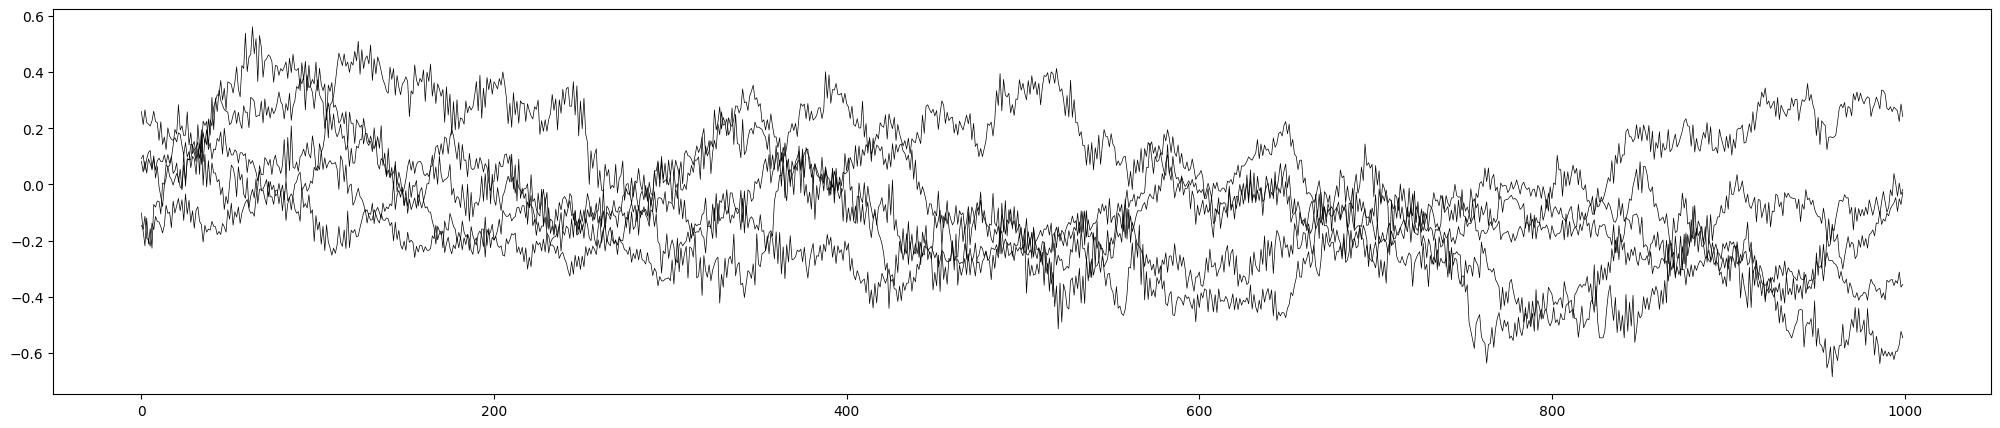

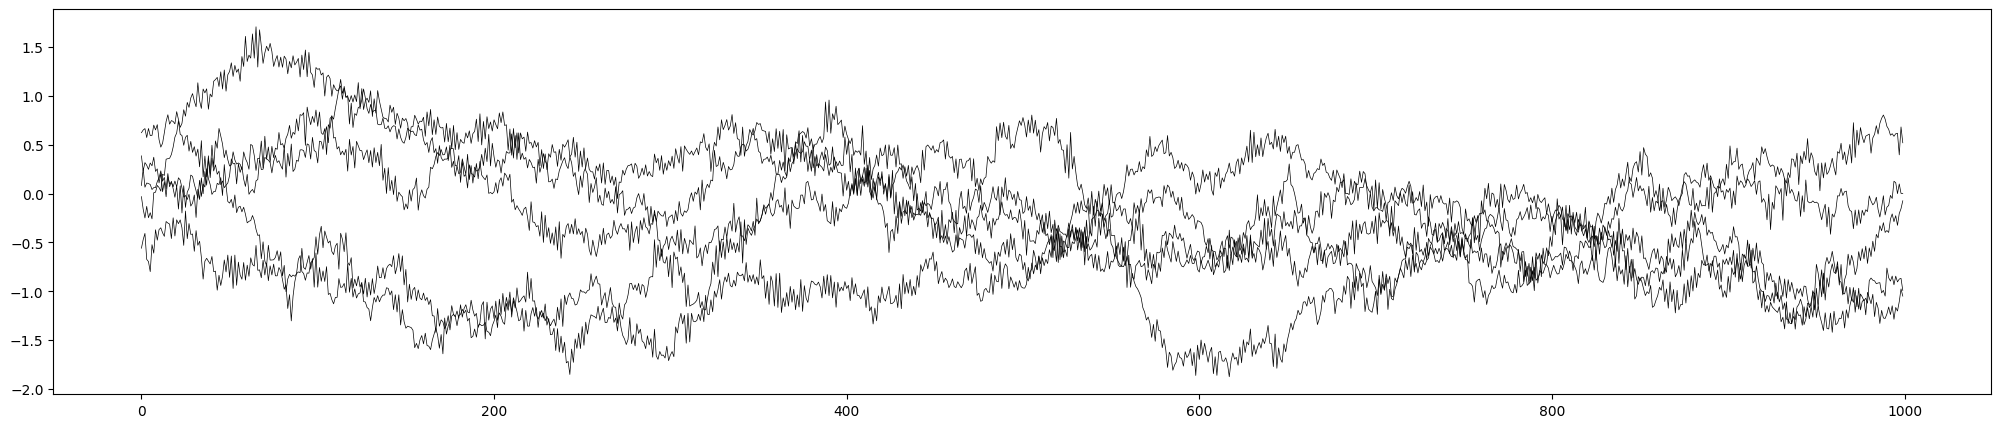

In [317]:
plt.plot((beta@f_hat.T).T, c='black', linewidth=0.5);
plt.figure()
plt.plot(f, c='black', linewidth=0.5)

In [318]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=5)
cca.fit(X=f_hat, Y=f)

CCA(n_components=5)

In [319]:
cca.score(f_hat, f)

0.9636010143990683

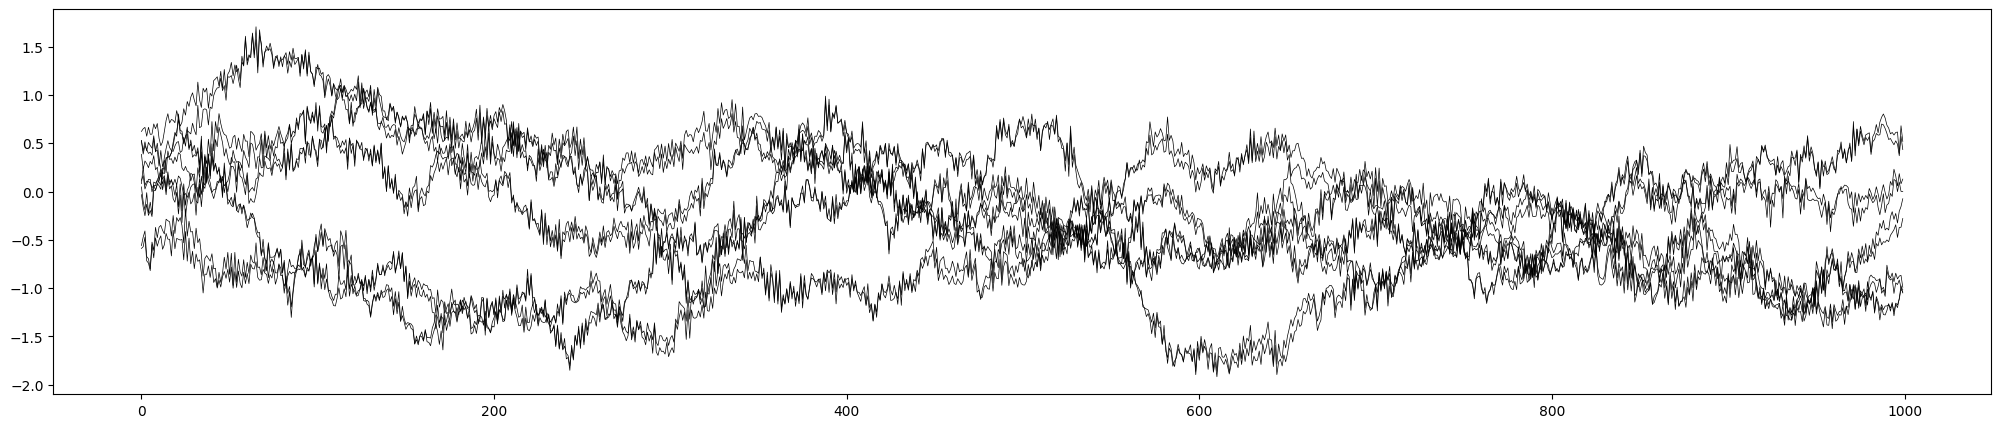

In [321]:
plt.plot(cca.predict(f_hat),  c='black', linewidth=0.5)
plt.plot(f, c='black', linewidth=0.5)

In [284]:
cca.x_loadings_

array([[-0.43750242,  0.77978638, -0.2736465 ,  0.11062488,  0.3135346 ],
       [-0.38752098, -0.1182744 , -0.59781774,  0.77837161, -0.31097472],
       [-0.34004419,  0.27945024,  0.7879441 ,  0.30779222, -0.51259308],
       [-0.19288135, -0.62892401,  0.12157674,  0.47514753,  0.70029709],
       [ 0.85678752,  0.17206361, -0.28027878,  0.24897414,  0.22764688]])

In [323]:
from statsmodels.multivariate.cancorr import CanCorr

In [325]:
cc = CanCorr(f_hat, f)

In [328]:
cc.x_cancoef

array([[ 0.01617331, -0.01525057, -0.04256741, -0.06501472, -0.0379268 ],
       [ 0.01367609, -0.01692355,  0.06309864, -0.00143526,  0.04541226],
       [ 0.01416771, -0.0194285 ,  0.010628  ,  0.06483933, -0.03675541],
       [-0.03385105, -0.03986653, -0.00166414, -0.01479387, -0.02201003],
       [ 0.00442403,  0.0362111 ,  0.0454836 , -0.03352756, -0.06283297]])

In [329]:
cc.y_cancoef

array([[-0.0064259 ,  0.02666787,  0.02548694,  0.11751951,  0.01696804],
       [ 0.05040554,  0.05515909, -0.07111964,  0.01226302, -0.03064845],
       [-0.00555012, -0.07508336, -0.0691373 ,  0.04123045,  0.03473523],
       [ 0.03016747, -0.01385736,  0.06302695,  0.0040864 , -0.12825375],
       [ 0.04197683, -0.01463615,  0.03520649,  0.04270358,  0.18076977]])

In [332]:
np.mean(cc.cancorr)

0.9855632826836448

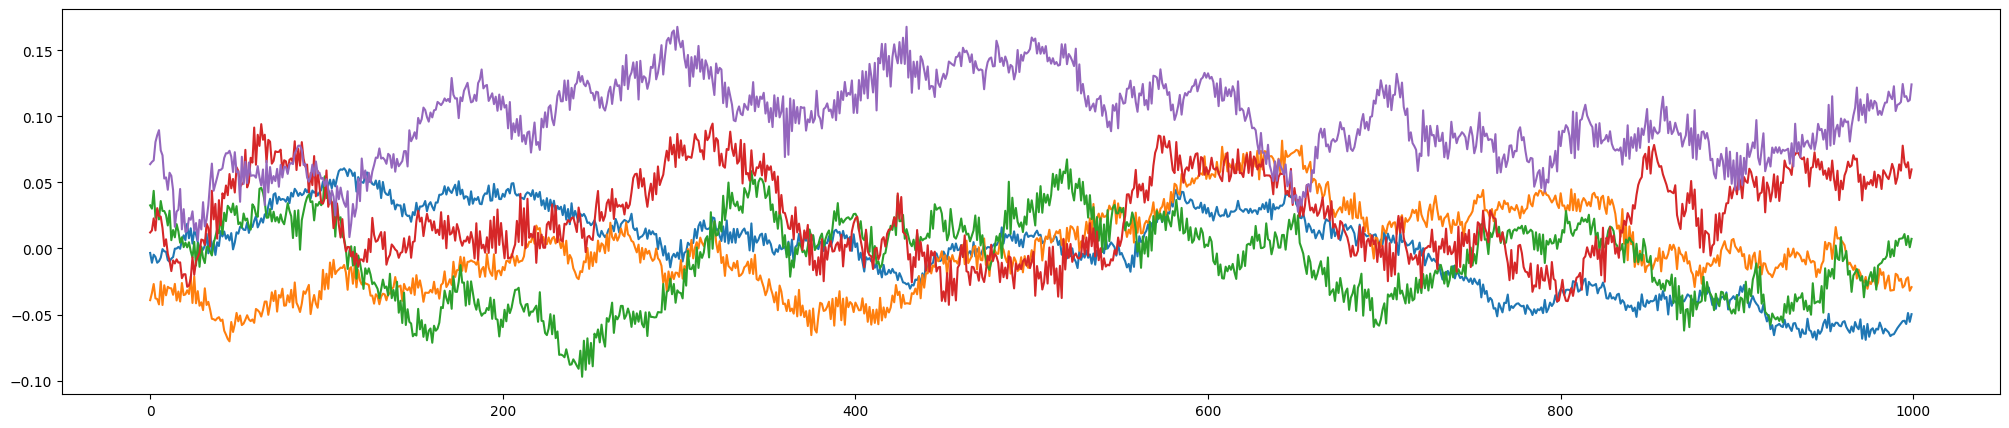

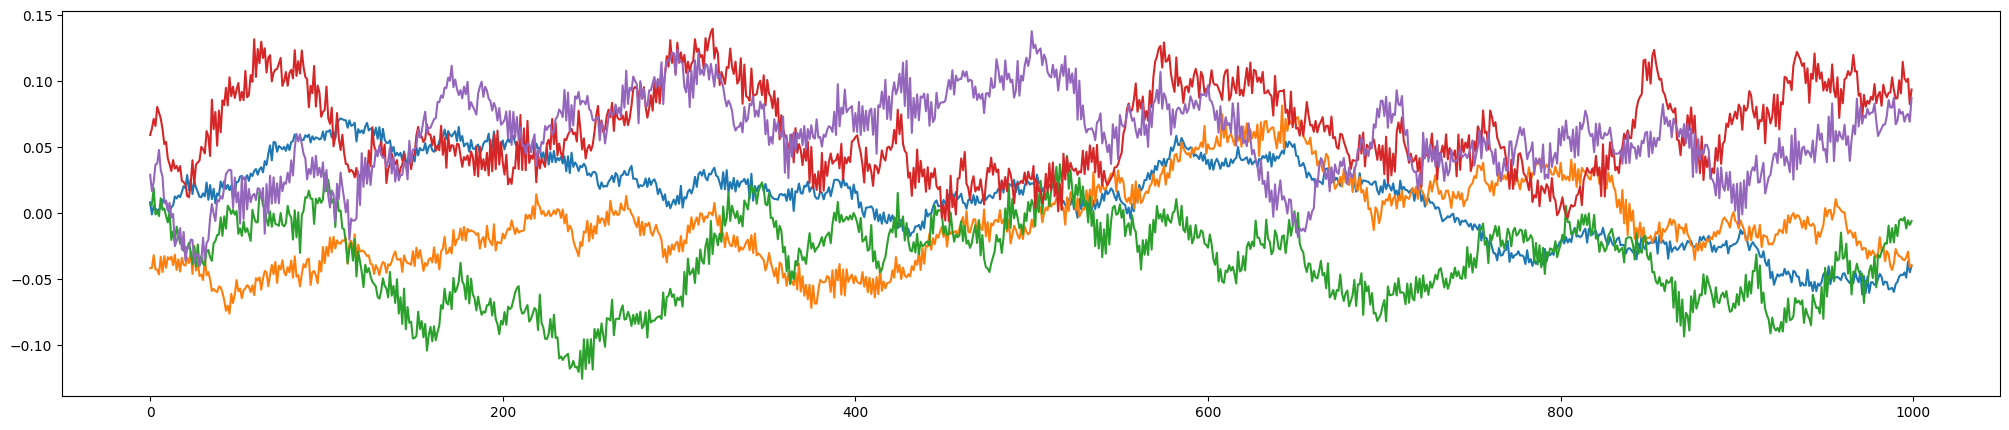

In [340]:
plt.plot(f_hat @ cc.y_cancoef )
plt.figure()
plt.plot(f @ cc.x_cancoef )